In [12]:
from __future__ import print_function

import numpy as np
import reflexxes
import random
import math

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# from hmmlearn import hmm
# from scipy.optimize import linear_sum_assignment
# from sklearn.metrics.pairwise import euclidean_distances

In [75]:
def plot_trajectory(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')

In [3]:
def save_to_csv(data, file_name):
    pos_list = []
    for pos in data:
        pos_list.append(pos)
    np.savetxt('data/' + file_name + '.csv', np.array(pos_list))

In [4]:
# used to generate velocity, position and acceleration
def generate_random_variable(lower_limit, higher_limit):
    return [random.randrange(lower_limit, higher_limit), 
            random.randrange(lower_limit, higher_limit), 
            random.randrange(lower_limit, higher_limit)]

In [5]:
def generate_trajectory_recur(gen, count=0, position=None, velocity=None, acceleration=None):
    # set initial values
    gen.current_position = position[-1] if position else generate_random_variable(0, 100)
    gen.current_velocity = velocity[-1] if velocity else generate_random_variable(-10, 10)
    gen.current_acceleration = acceleration[-1] if acceleration else generate_random_variable(0, 5)

    position = position or [gen.current_position.tolist()]
    velocity = velocity or [gen.current_velocity.tolist()]
    acceleration = acceleration or [gen.current_acceleration.tolist()]

    target_position = generate_random_variable(0, 100)
    target_velocity = generate_random_variable(-10, 10)
    
    # generate trajectory
    for pos, vel, acc in gen.trajectory(target_position, target_velocity, 1):
        '''
        auto trajectory(const RMLDoubleVector& target_position,
                    const RMLDoubleVector& target_velocity,
                    double min_sync_time = 0.0)
                    '''
        position.append(pos)
        velocity.append(vel)
        acceleration.append(acc)
        
    if count == 0:
        return position, velocity, acceleration
    else:
        return generate_trajectory_recur(gen, count - 1, position, velocity, acceleration)

In [19]:
# arg1: list of positions
# arg2: the rate of outliers to be generated in the list
# return: list of positions with outliers, list of indices of outliers in the position list
def add_outliers(positions, outlier_rate=0.0001):
    num = math.floor(len(positions) * outlier_rate)
    choices = random.sample(range(len(positions)), num)
    choices.sort()
    for i in choices:
        positions[i] = generate_random_variable(0, 100)
    return positions, choices

In [6]:
'''
explicit PositionTrajectoryGenerator(unsigned number_of_dofs,
                                    double cycle_time,
                                    const RMLDoubleVector& max_velocity,
                                    const RMLDoubleVector& max_acceleration,
                                    const RMLDoubleVector& max_jerk)
'''
gen = reflexxes.extra.PositionTrajectoryGenerator(
    number_of_dofs=3,
    cycle_time=0.01,
    max_velocity=[10, 10, 10],
    max_acceleration=[8, 8, 8],
    max_jerk=[4, 5, 6]
)

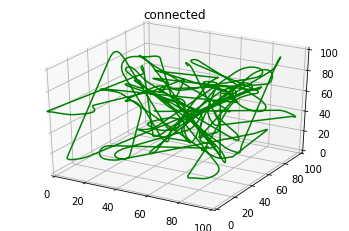

In [148]:
p, v, a = generate_trajectory_recur(gen, 64)
plot_trajectory(p, "connected")

In [149]:
# arg1: list of positions
# arg2: the rate of outliers to be generated in the list
# return: list of positions with outliers, list of indices of outliers in the position list
p, c = add_outliers(p, 0.001)

In [150]:
len(p)

48334

In [151]:
len(c)

48

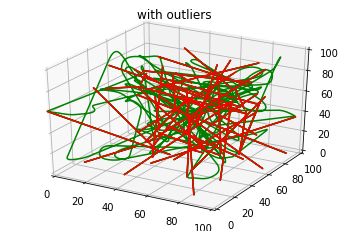

In [152]:
plot_trajectory(p, "with outliers", c)

In [153]:
save_to_csv(p, "outlier_0.001")